**Visualization:**
* Display a Blocks object

Translate from blocks to tensor?

**Diffusion:**
* Generate a random square of blocks

In [1]:
from minecraft_pb2 import *
import minecraft_pb2_grpc

import matplotlib.pyplot as plt
import numpy as np

In [2]:
exampleBlocks = Blocks(blocks=[ 
    Block(position=Point(x=0, y=5, z=-1), type=PISTON, orientation=NORTH),
    Block(position=Point(x=-1, y=5, z=0), type=PISTON, orientation=WEST),
    Block(position=Point(x=0, y=5, z=1), type=PISTON, orientation=SOUTH),
    Block(position=Point(x=1, y=5, z=0), type=PISTON, orientation=EAST),
])
#Example fetching command
#exampleBlocks.blocks[1]

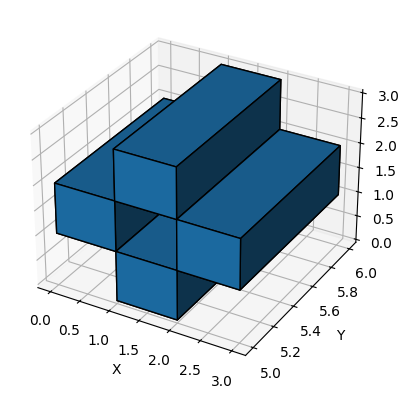

In [35]:
ax = plt.figure().add_subplot(projection='3d')
arr = np.zeros((8, 8, 8))

for block in exampleBlocks.blocks:
    arr[block.position.x + 1, block.position.y, block.position.z + 1] = block.type

ax.voxels(arr, edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

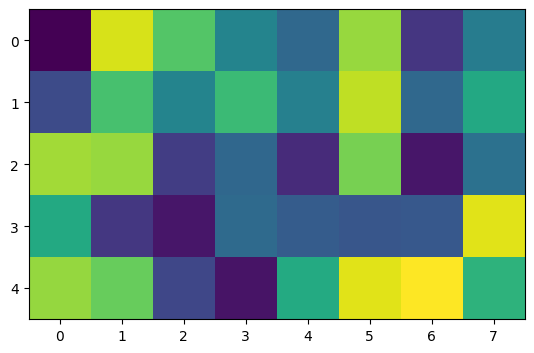

In [ ]:
# Ill make a block generator.
# Generate a plane and visualize it.
# Ill also generate a function to translate between array and block repressentation

#len(BlockType.items())
randomSquare = np.random.randint(0, 255, size=(5, 8), dtype=np.uint8)
fig = plt.figure()
plt.imshow(randomSquare)

In [75]:
#Block translation. Mapping is weird

blockTranslation = (lambda v, x, y:
    Block(position=Point(x=x, y=0, z=y), type=v, orientation=NORTH),
    )

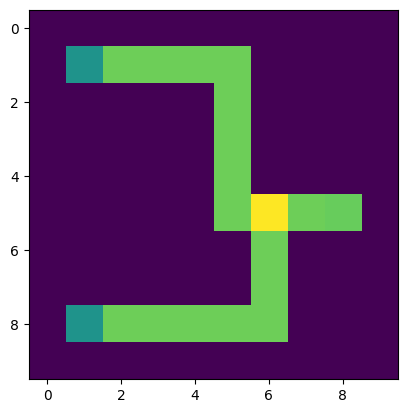

In [110]:
#What now?
# make an example redstone circuit in 2d.
# Diffuse it.
# Display it.

redstoneCircuit = np.zeros((10,10))
redstoneCircuit[1,1] = LEVER
redstoneCircuit[8,1] = LEVER
redstoneCircuit[5,8] = REDSTONE_LAMP
redstoneCircuit[5,6] = UNPOWERED_COMPARATOR

redstoneCircuit[1,2:6] = REDSTONE_WIRE
redstoneCircuit[1:6,5] = REDSTONE_WIRE
redstoneCircuit[8,2:7] = REDSTONE_WIRE
redstoneCircuit[6:8,6] = REDSTONE_WIRE
redstoneCircuit[5,7] = REDSTONE_WIRE

plt.imshow(redstoneCircuit)

In [2]:
import torch
import diffusers
from tqdm import tqdm
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


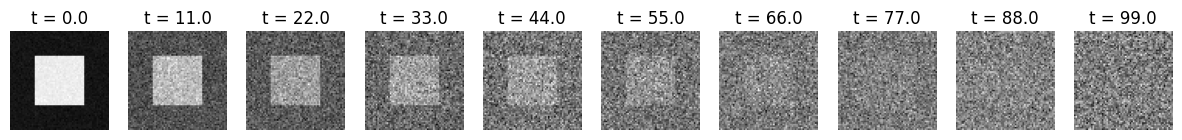

In [3]:
# Load or create a 2D image (grayscale)
image_size = 64  # 64x64 pixels
timesteps = 100  # Number of diffusion steps

# Create a sample 2D image (a square in the middle)
image = torch.zeros((image_size, image_size))
image[16:48, 16:48] = 1.0  # A white square

# Convert to tensor and add batch/channel dimensions
image = image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 64, 64)

scheduler = diffusers.DDPMScheduler(num_train_timesteps=100, beta_schedule="squaredcos_cap_v2")

fig, axes = plt.subplots(1, 10, figsize=(15, 3))

steps = np.linspace(0, 99, 10)

for i, t in enumerate(steps):
    timestep_tensor = torch.tensor([t], dtype=torch.long)
    noisy_image = scheduler.add_noise(image, torch.randn_like(image), timestep_tensor)
    axes[i].imshow(noisy_image.squeeze().numpy(), cmap="gray")
    axes[i].set_title(f"t = {t}")
    axes[i].axis("off")

plt.show()

In [4]:
transformation = transforms.Compose([transforms.Normalize((0.5), (0.5))])
image = transformation(image)

In [4]:
#diffusers.DDPMScheduler()?
#diffusers.UNet2DModel?
#diffusers.AutoencoderKL

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Define the model: UNet for 2D diffusion
model = diffusers.UNet2DModel(
    sample_size=image_size,  # Image size
    in_channels=1,  # Grayscale image
    out_channels=1,  # Predict noise for 1-channel images
    layers_per_block=2,
    #block_out_channels=(32, 64, 128),
    block_out_channels=(128, 128, 256, 512),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Loss function (MSE)
criterion = torch.nn.MSELoss()

Using device: cuda


# Below deepseek solution

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
# Training loop
model.train()  # Set model to training mode
# Create a simple dataset class for your image
class SingleImageDataset(Dataset):
    def __init__(self, images):
        self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        return {'image': image}

# Initialize the dataset and dataloader
dataset = SingleImageDataset(image)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

num_epochs = 50
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(dataloader):
        images = batch['image'].to(device)
        
        # Random timestep between 0 and timesteps -1
        t = torch.randint(0, timesteps-1, (images.shape[0],), device=device).long()
        timesteps_tensor = torch.full((images.shape[0],), t[0], device=device, dtype=torch.long)
        
        # Get the noisy image using scheduler.add_noise
        noise = torch.randn_like(images)  # Random noise for the current timestep
        noisy_image = scheduler.add_noise(images, noise, timesteps_tensor)
        
        timestep_tensor = timestep_tensor.to(device)
        
        # Predict the noise with the model
        predicted_noise = model(noisy_image, timestep_tensor).sample
        
        # Compute loss
        loss = criterion(predicted_noise.squeeze(), noise)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

print("Training completed.")

c:\Mine\Master\MyNca\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 64, 64])) that is different to the input size (torch.Size([64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Loss: 1.2707750797271729
Epoch 2/50, Loss: 1.1751277446746826
Epoch 3/50, Loss: 0.5668038129806519
Epoch 4/50, Loss: 0.27013641595840454
Epoch 5/50, Loss: 0.9042757749557495
Epoch 6/50, Loss: 0.15755121409893036
Epoch 7/50, Loss: 0.18628230690956116
Epoch 8/50, Loss: 0.22888131439685822
Epoch 9/50, Loss: 0.13976061344146729
Epoch 10/50, Loss: 0.1524154543876648
Epoch 11/50, Loss: 0.17037439346313477
Epoch 12/50, Loss: 0.1448073387145996
Epoch 13/50, Loss: 0.12109479308128357
Epoch 14/50, Loss: 0.08783746510744095
Epoch 15/50, Loss: 0.4952026605606079
Epoch 16/50, Loss: 0.13820695877075195
Epoch 17/50, Loss: 0.06721062958240509
Epoch 18/50, Loss: 0.22669413685798645
Epoch 19/50, Loss: 0.1591220200061798
Epoch 20/50, Loss: 0.07480740547180176
Epoch 21/50, Loss: 0.5986801385879517
Epoch 22/50, Loss: 0.0685003474354744
Epoch 23/50, Loss: 0.12506750226020813
Epoch 24/50, Loss: 0.06578397750854492
Epoch 25/50, Loss: 0.27724552154541016
Epoch 26/50, Loss: 0.07169780880212784
Epoch

In [10]:
# Evaluation/inference setup
model.eval()

# Inference loop
n_inference_steps = 100
scheduler.set_timesteps(n_inference_steps)

# Generate samples starting from random noise at t=999 and move to t=0
sampled_images = []
current_noise = torch.randn((1, 1, image_size, image_size), device=device)
with torch.no_grad():
    for step in scheduler.timesteps:
    #for step in reversed(range(n_inference_steps)):
        timestep_tensor = torch.full((1,), step, device=current_noise.device, dtype=torch.long)
        #current_image = scheduler.step(current_noise, timestep_tensor, model).images

        predicted_noise = model(current_noise, timestep_tensor).sample
        current_image = scheduler.step(predicted_noise, timestep_tensor, current_noise).prev_sample

        sampled_images.append(current_image.cpu().numpy())

# Convert to array and display the samples
sampled_images = np.stack(sampled_images, axis=0)
print(f"Inference completed. Generated samples shape: {sampled_images.shape}")


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

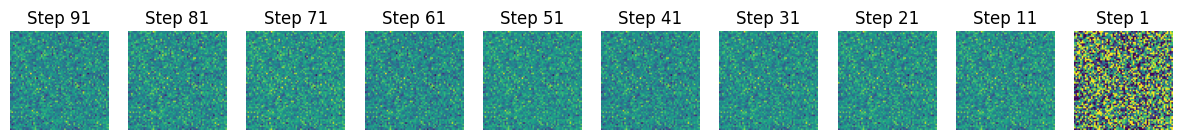

In [9]:
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(sampled_images[i*10 + 9, 0, 0])
    plt.axis('off')
    plt.title(f"Step {n_inference_steps - i*10 -9}")
plt.show()

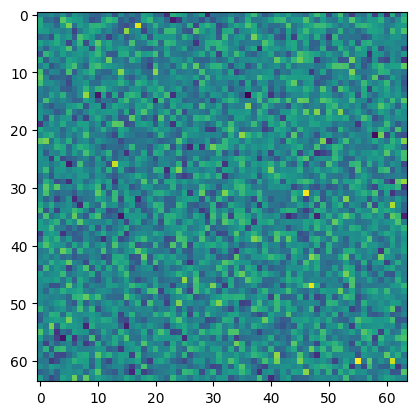

In [13]:
#plt.imshow(sampled_images[99, 0, 0])
#plt.imshow(image[0, 0])
plt.imshow(current_noise.squeeze().cpu())

# Below GPT solution

In [16]:
# Training settings
num_epochs = 5000  # Training iterations

model.train()  # Set model to training mode
image = image.to(device)  # Move image to device
# Training loop
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()

    # Select a random timestep
    t = torch.randint(0, timesteps, (1,), device=device).long()

    # Generate random noise
    noise = torch.randn_like(image, device=device)

    # Diffuse the image
    noisy_image = scheduler.add_noise(image, noise, t)

    # Predict noise using the model
    predicted_noise = model(noisy_image, t).sample  # UNet output

    # Compute loss (difference between predicted and actual noise)
    loss = criterion(predicted_noise, noise)
    loss.backward()

    # Optimize
    optimizer.step()

    # Print loss every 500 epochs
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


  0%|          | 4/5000 [00:00<10:05,  8.25it/s]

Epoch 0, Loss: 1.0965


 10%|█         | 506/5000 [00:22<02:58, 25.17it/s]

Epoch 500, Loss: 0.0251


 11%|█▏        | 569/5000 [00:25<03:19, 22.22it/s]


KeyboardInterrupt: 

[999. 888. 777. 666. 555. 444. 333. 222. 111.   0.]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


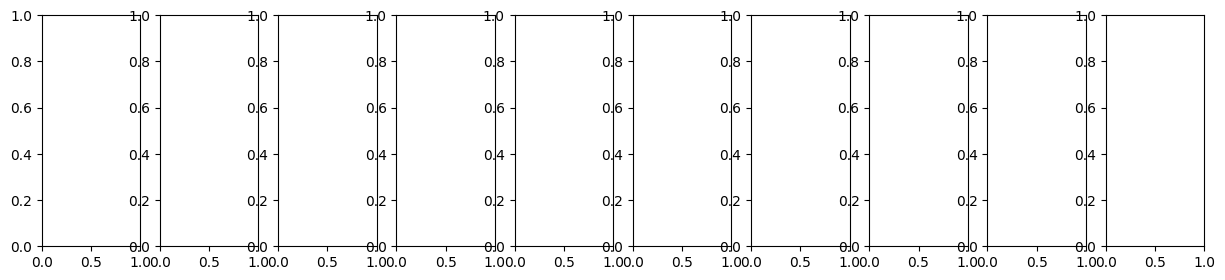

In [17]:
# Generate an image from noise
model.eval()

z = torch.randn((1, 1, image_size, image_size), device=device)  # Start with random noise

fig, axes = plt.subplots(1, 10, figsize=(15, 3))
timesteps = np.linspace(999, 0, 10)
print(timesteps)

for i, t in enumerate(timesteps):
    t_tensor = torch.tensor([t], dtype=torch.long, device=device)
    
    with torch.no_grad():
        predicted_noise = model(z, t_tensor).sample  # Predict noise
    
    # Remove predicted noise
    newz = scheduler.step(predicted_noise, t_tensor, z).prev_sample
    
    # Visualize intermediate denoised images
    axes[i].imshow(newz.squeeze().cpu().numpy(), cmap="gray")
    axes[i].set_title(f"t = {t}")
    axes[i].axis("off")

plt.show()


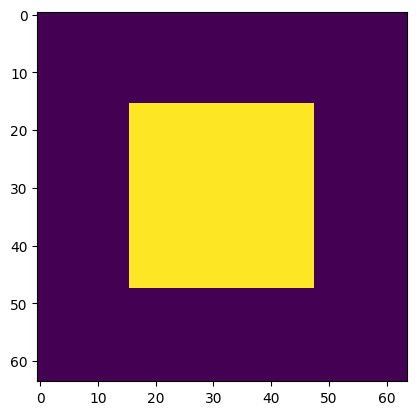

In [62]:
plt.imshow(image.squeeze().cpu().numpy())